In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from accelerate import Accelerator

from collections.abc import Iterable

from preprocessor import load_and_preprocess, decoding, get_dataset
from qwen import load_qwen

import numpy as np

import matplotlib.pyplot as plt

import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

import pandas as pd

/home/ljf1/dis/lora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#for matplotlib plots
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
# load hyperparameters from file
file_path = "../results/best_overall_params.pt"
best_overall_params = torch.load(file_path, weights_only=False, map_location=torch.device('cpu'))

lora_rank = best_overall_params['lora_rank']
lora_alpha = lora_rank
batch_size = 4
learning_rate = best_overall_params['learning_rate']
test_size = 0.2
max_ctx_length = best_overall_params['max_ctx_length']
points = 80

In [4]:
def running_mse(prediction, actual):
    """
    Calculate running MSE comparing the prediction and actual values.

    Args:
        prediction (ndarray): Predicted values.
        actual (ndarray): Actual values.

    Returns:
        mse (list): List of running MSE values.
    """
    mse = []
    for i in range(len(prediction)):
        mse.append(mean_squared_error(prediction[:i+1], actual[:i+1]))
    return mse

def get_metrics(actual_preys, actual_predators, pred_preys, pred_predators):
    """
    Calculate metrics for predator and prey time series data comparing predicted and actual data.

    Args:
        actual_preys (ndarray): Actual prey values.
        actual_predators (ndarray): Actual predator values.
        pred_preys (ndarray): Predicted prey values.
        pred_predators (ndarray): Predicted predator values.
    
    Returns:
        metrics (list): List of tuples containing calculated metrics for prey and predator.
    """
    metrics = []
    for actual_prey, actual_predator, pred_prey, pred_predator in zip(actual_preys, actual_predators, pred_preys, pred_predators):
        mse_prey = mean_squared_error(actual_prey[80:], pred_prey[80:])
        mse_predator = mean_squared_error(actual_predator[80:], pred_predator[80:])
        mae_prey = mean_absolute_error(actual_prey[80:], pred_prey[80:])
        mae_predator = mean_absolute_error(actual_predator[80:], pred_predator[80:])
        mape_prey = mean_absolute_percentage_error(actual_prey[80:], pred_prey[80:])
        mape_predator = mean_absolute_percentage_error(actual_predator[80:], pred_predator[80:])
        rmse_prey = root_mean_squared_error(actual_prey[80:], pred_prey[80:])
        rmse_predator = root_mean_squared_error(actual_predator[80:], pred_predator[80:])
        running_mse_prey = running_mse(pred_prey[80:], actual_prey[80:])
        running_mse_predator = running_mse(pred_predator[80:], actual_predator[80:])
        metrics.append((mse_prey, mse_predator, mae_prey, mae_predator, mape_prey, mape_predator, rmse_prey, rmse_predator, running_mse_prey, running_mse_predator))
    return metrics

def move_to_cpu(obj):
    """
    Recursively convert tensors to CPU NumPy arrays.
    
    Args:
        obj (any): Input object (tensor, NumPy array, list, dict, etc.).
    Returns:
        obj (any): Object moved to CPU.
    """
    if isinstance(obj, torch.Tensor):
        # Move tensor to CPU and convert to NumPy
        return obj.detach().cpu().numpy()
    
    elif isinstance(obj, np.ndarray):
        # Already a NumPy array (no action needed)
        return obj
    
    elif isinstance(obj, dict):
        # Process dictionary values and recursively move to cpu
        return {k: move_to_cpu(v) for k, v in obj.items()}
    
    elif isinstance(obj, Iterable) and not isinstance(obj, str):
        # Process lists, tuples, etc.
        return type(obj)(move_to_cpu(v) for v in obj)
    
    else:
        # Return Python primitives (int, float, etc.) as-is
        return obj

In [5]:
# initialise accelerator
accelerator = Accelerator()

In [6]:
class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear)
        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False
        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        device = original_linear.weight.device
        self.A = nn.Parameter(torch.empty(r, in_dim, device=device))
        self.B = nn.Parameter(torch.zeros(out_dim, r, device=device))
        
        # Initialise A with He initialization
        nn.init.kaiming_normal_(self.A, nonlinearity="linear")

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = (x @ self.A.T) @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)


model, tokenizer = load_qwen()
tokenizer.padding_side = 'left'

# Actually apply LoRA to the model:
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank, alpha = lora_alpha)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank, alpha = lora_alpha)
# ^These are the parts that will actually be trained!

for name, param in model.named_parameters():
    if "A" in name or "B" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [7]:
# Load the saved LoRA weights
model_name = "CSD3_15k_seed_defaults_best"
saved_model_path = f"../models/{model_name}_lora_weights.pt"
lora_state_dict = torch.load(saved_model_path)
print(f"Loading LoRA weights from {saved_model_path}")

# Extract configuration
loaded_config = lora_state_dict.get('config', {})
print(f"Loaded model config: {loaded_config}")

# Load weights into model
for i, layer in enumerate(model.model.layers):
    # Load Q projection LoRA weights
    if f'layer_{i}.self_attn.q_proj.A' in lora_state_dict:
        layer.self_attn.q_proj.A.data = lora_state_dict[f'layer_{i}.self_attn.q_proj.A'].to(layer.self_attn.q_proj.A.device)
        layer.self_attn.q_proj.B.data = lora_state_dict[f'layer_{i}.self_attn.q_proj.B'].to(layer.self_attn.q_proj.B.device)
    
    # Load V projection LoRA weights
    if f'layer_{i}.self_attn.v_proj.A' in lora_state_dict:
        layer.self_attn.v_proj.A.data = lora_state_dict[f'layer_{i}.self_attn.v_proj.A'].to(layer.self_attn.v_proj.A.device)
        layer.self_attn.v_proj.B.data = lora_state_dict[f'layer_{i}.self_attn.v_proj.B'].to(layer.self_attn.v_proj.B.device)

print("LoRA weights loaded successfully")

Loading LoRA weights from ../models/CSD3_15k_seed_defaults_best_lora_weights.pt
Loaded model config: {'lora_rank': 8, 'lora_alpha': 8, 'max_ctx_length': 768}
LoRA weights loaded successfully


In [8]:
# Process the data into sequences of text
np.random.seed(442)
_, _, test_texts = load_and_preprocess("lotka_volterra_data.h5", test_size=test_size)

def process_data(texts, tokenizer, points=80):
    """
    Process test data into sequences of text and tokenize them.

    Args:
        texts (list): List of text sequences.
        tokenizer (Tokenizer): Tokenizer to use for processing.
        points (int): Number of points to consider.

    Returns:
        tuple: Tuple containing the processed texts and their corresponding tokenized input IDs.
    """
    given_input_ids = []
    for text in texts:
        given_text = ';'.join([chunk for i, chunk in enumerate(text.split(';')) if i < points])
        encoding_given = tokenizer(given_text, return_tensors="pt", padding='max_length', padding_side='left', max_length=1200)
        given_input_ids.append(encoding_given.input_ids[0])
    return np.stack([text for text in texts]), torch.stack(given_input_ids)

# tokenize the test set
test_texts_all, test_input_ids_some = process_data(
    test_texts, tokenizer, points=points
)

# put test set into DataLoader
test_dataset = TensorDataset(test_input_ids_some)
test_loader = DataLoader(test_dataset, shuffle=False)

In [9]:
# prepare accelerator with test set
model, test_loader = accelerator.prepare(model, test_loader)

# predict specific systems
system_ids = [0, 10, 15, 91]
actual_system_ids = [506, 20, 654, 906]
prediction_decodeds = []
test_decodeds = []
model.eval()
with torch.no_grad():    
    for idx, (batch,) in enumerate(tqdm(test_loader)):
        if idx not in system_ids:
            continue
        outputs = model.generate(batch, attention_mask = torch.ones_like(batch), max_new_tokens=1300)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        prediction_decoded = decoding(prediction)
        prediction_decodeds.append(prediction_decoded)
        test_text = test_texts_all[idx]
        test_decoded = decoding(test_text)
        test_decodeds.append(test_decoded)

test_decodeds = np.array(test_decodeds)
prediction_decodeds = np.array(prediction_decodeds)

actual_preys = test_decodeds[:, 0]
actual_predators = test_decodeds[:, 1]
pred_preys = prediction_decodeds[:, 0]
pred_predators = prediction_decodeds[:, 1]

full_times = get_dataset("lotka_volterra_data.h5")[-1]

100%|██████████| 100/100 [03:44<00:00,  2.25s/it]


In [ ]:
# joblib.dump((actual_preys, actual_predators, pred_preys, pred_predators, full_times), "final_predictions.pkl")
actual_preys, actual_predators, pred_preys, pred_predators, full_times = joblib.load("final_predictions.pkl")

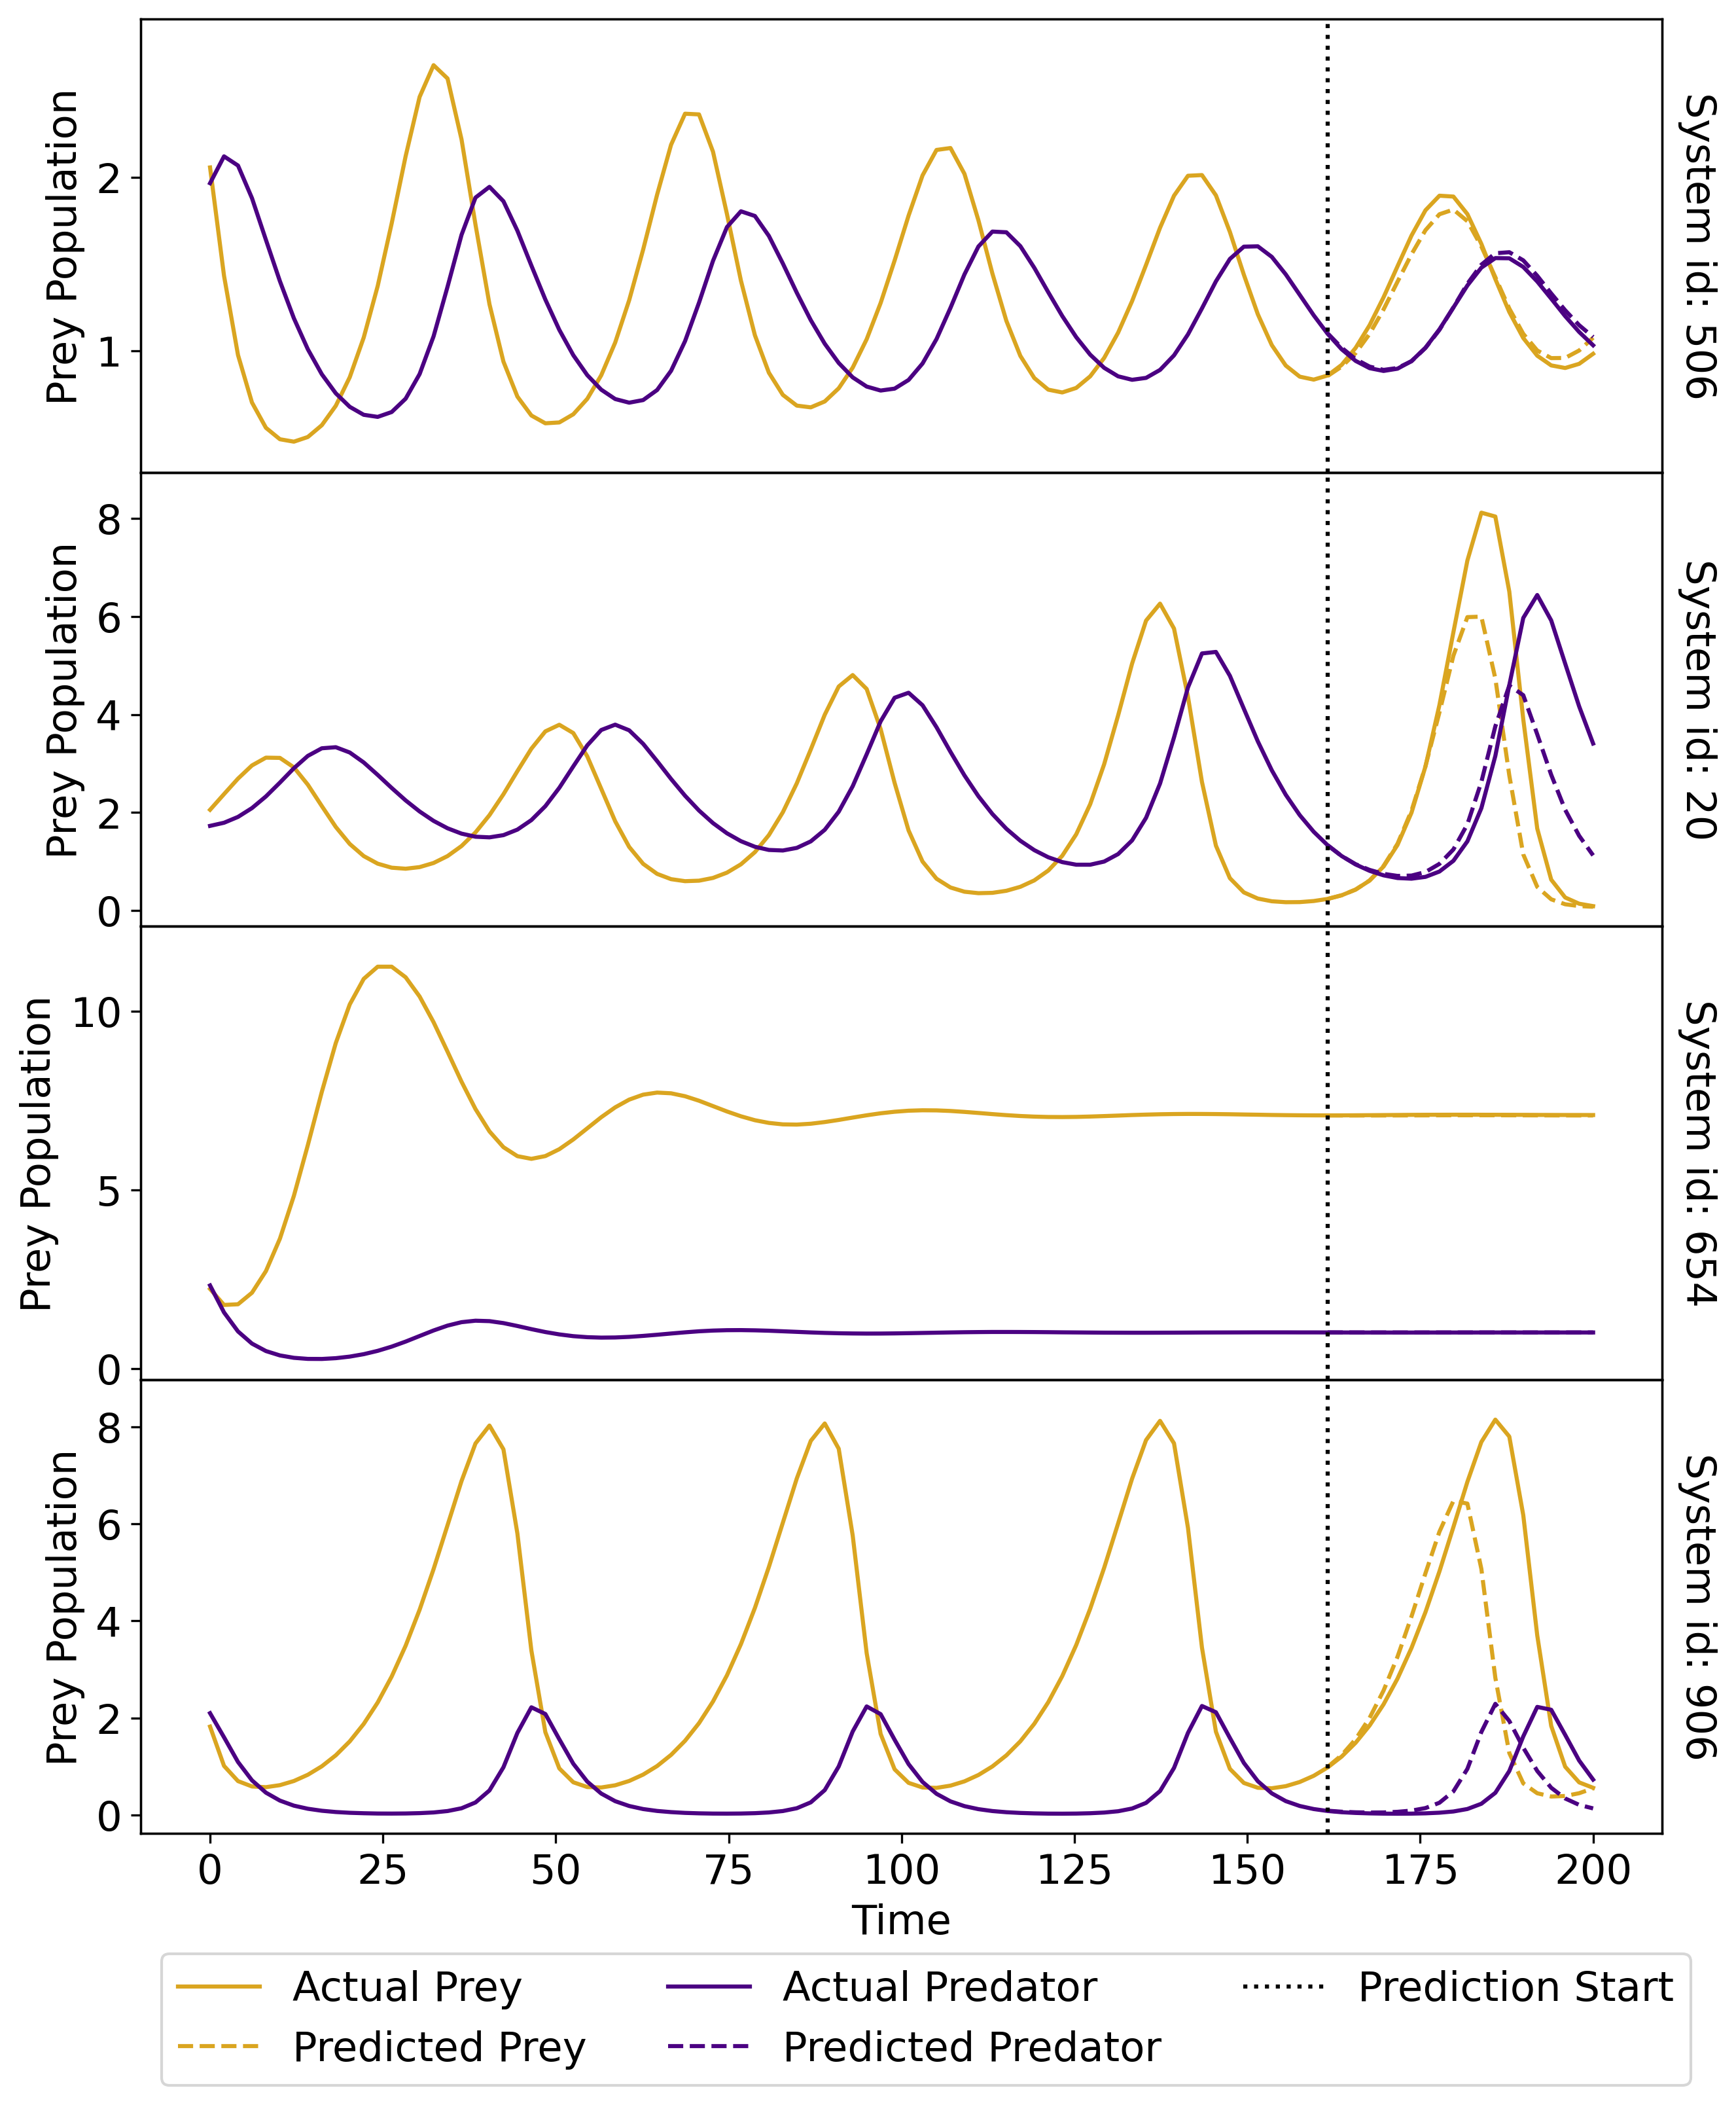

In [11]:
# plot the predictions
fig, ax = plt.subplots(len(actual_system_ids), 1, figsize=(10, 3*len(actual_system_ids)), sharex=True, dpi=300)
for i, id in enumerate(actual_system_ids):
    ax[i].plot(full_times, actual_preys[i], label='Actual Prey', color='goldenrod')
    ax[i].plot(full_times[80:], pred_preys[i][80:], label='Predicted Prey', color='goldenrod', linestyle='dashed')
    ax[i].plot(full_times, actual_predators[i], label='Actual Predator', color='indigo')
    ax[i].plot(full_times[80:], pred_predators[i][80:], label='Predicted Predator', color='indigo', linestyle='dashed')
    ax[i].axvline(x=full_times[80], color='black', linestyle='dotted', label='Prediction Start')
    twin_axis = ax[i].twinx()
    twin_axis.set_ylabel(fr'System id: {id}', rotation=270, fontsize=SMALL_SIZE-5, labelpad=20)
    twin_axis.set_yticks([])
    ax[i].set_ylabel('Prey Population')
    ax[i].set_ylim(min(actual_preys[i].min(), actual_predators[i].min())*0.9-0.05*max(actual_preys[i].max(), actual_predators[i].max()), max(actual_preys[i].max(), actual_predators[i].max())*1.1)
ax[-1].set_xlabel('Time')
for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=SMALL_SIZE-5)
    ax.set_ylabel(ax.get_ylabel(), fontsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='minor', labelsize=SMALL_SIZE-5)
ax.legend(loc='lower left', bbox_to_anchor=(0, -0.6), ncol=3, fontsize=SMALL_SIZE-5)
plt.subplots_adjust(hspace=0)
plt.savefig("../plots/predictions_lora_final.png", bbox_inches='tight', dpi=300)
plt.show()

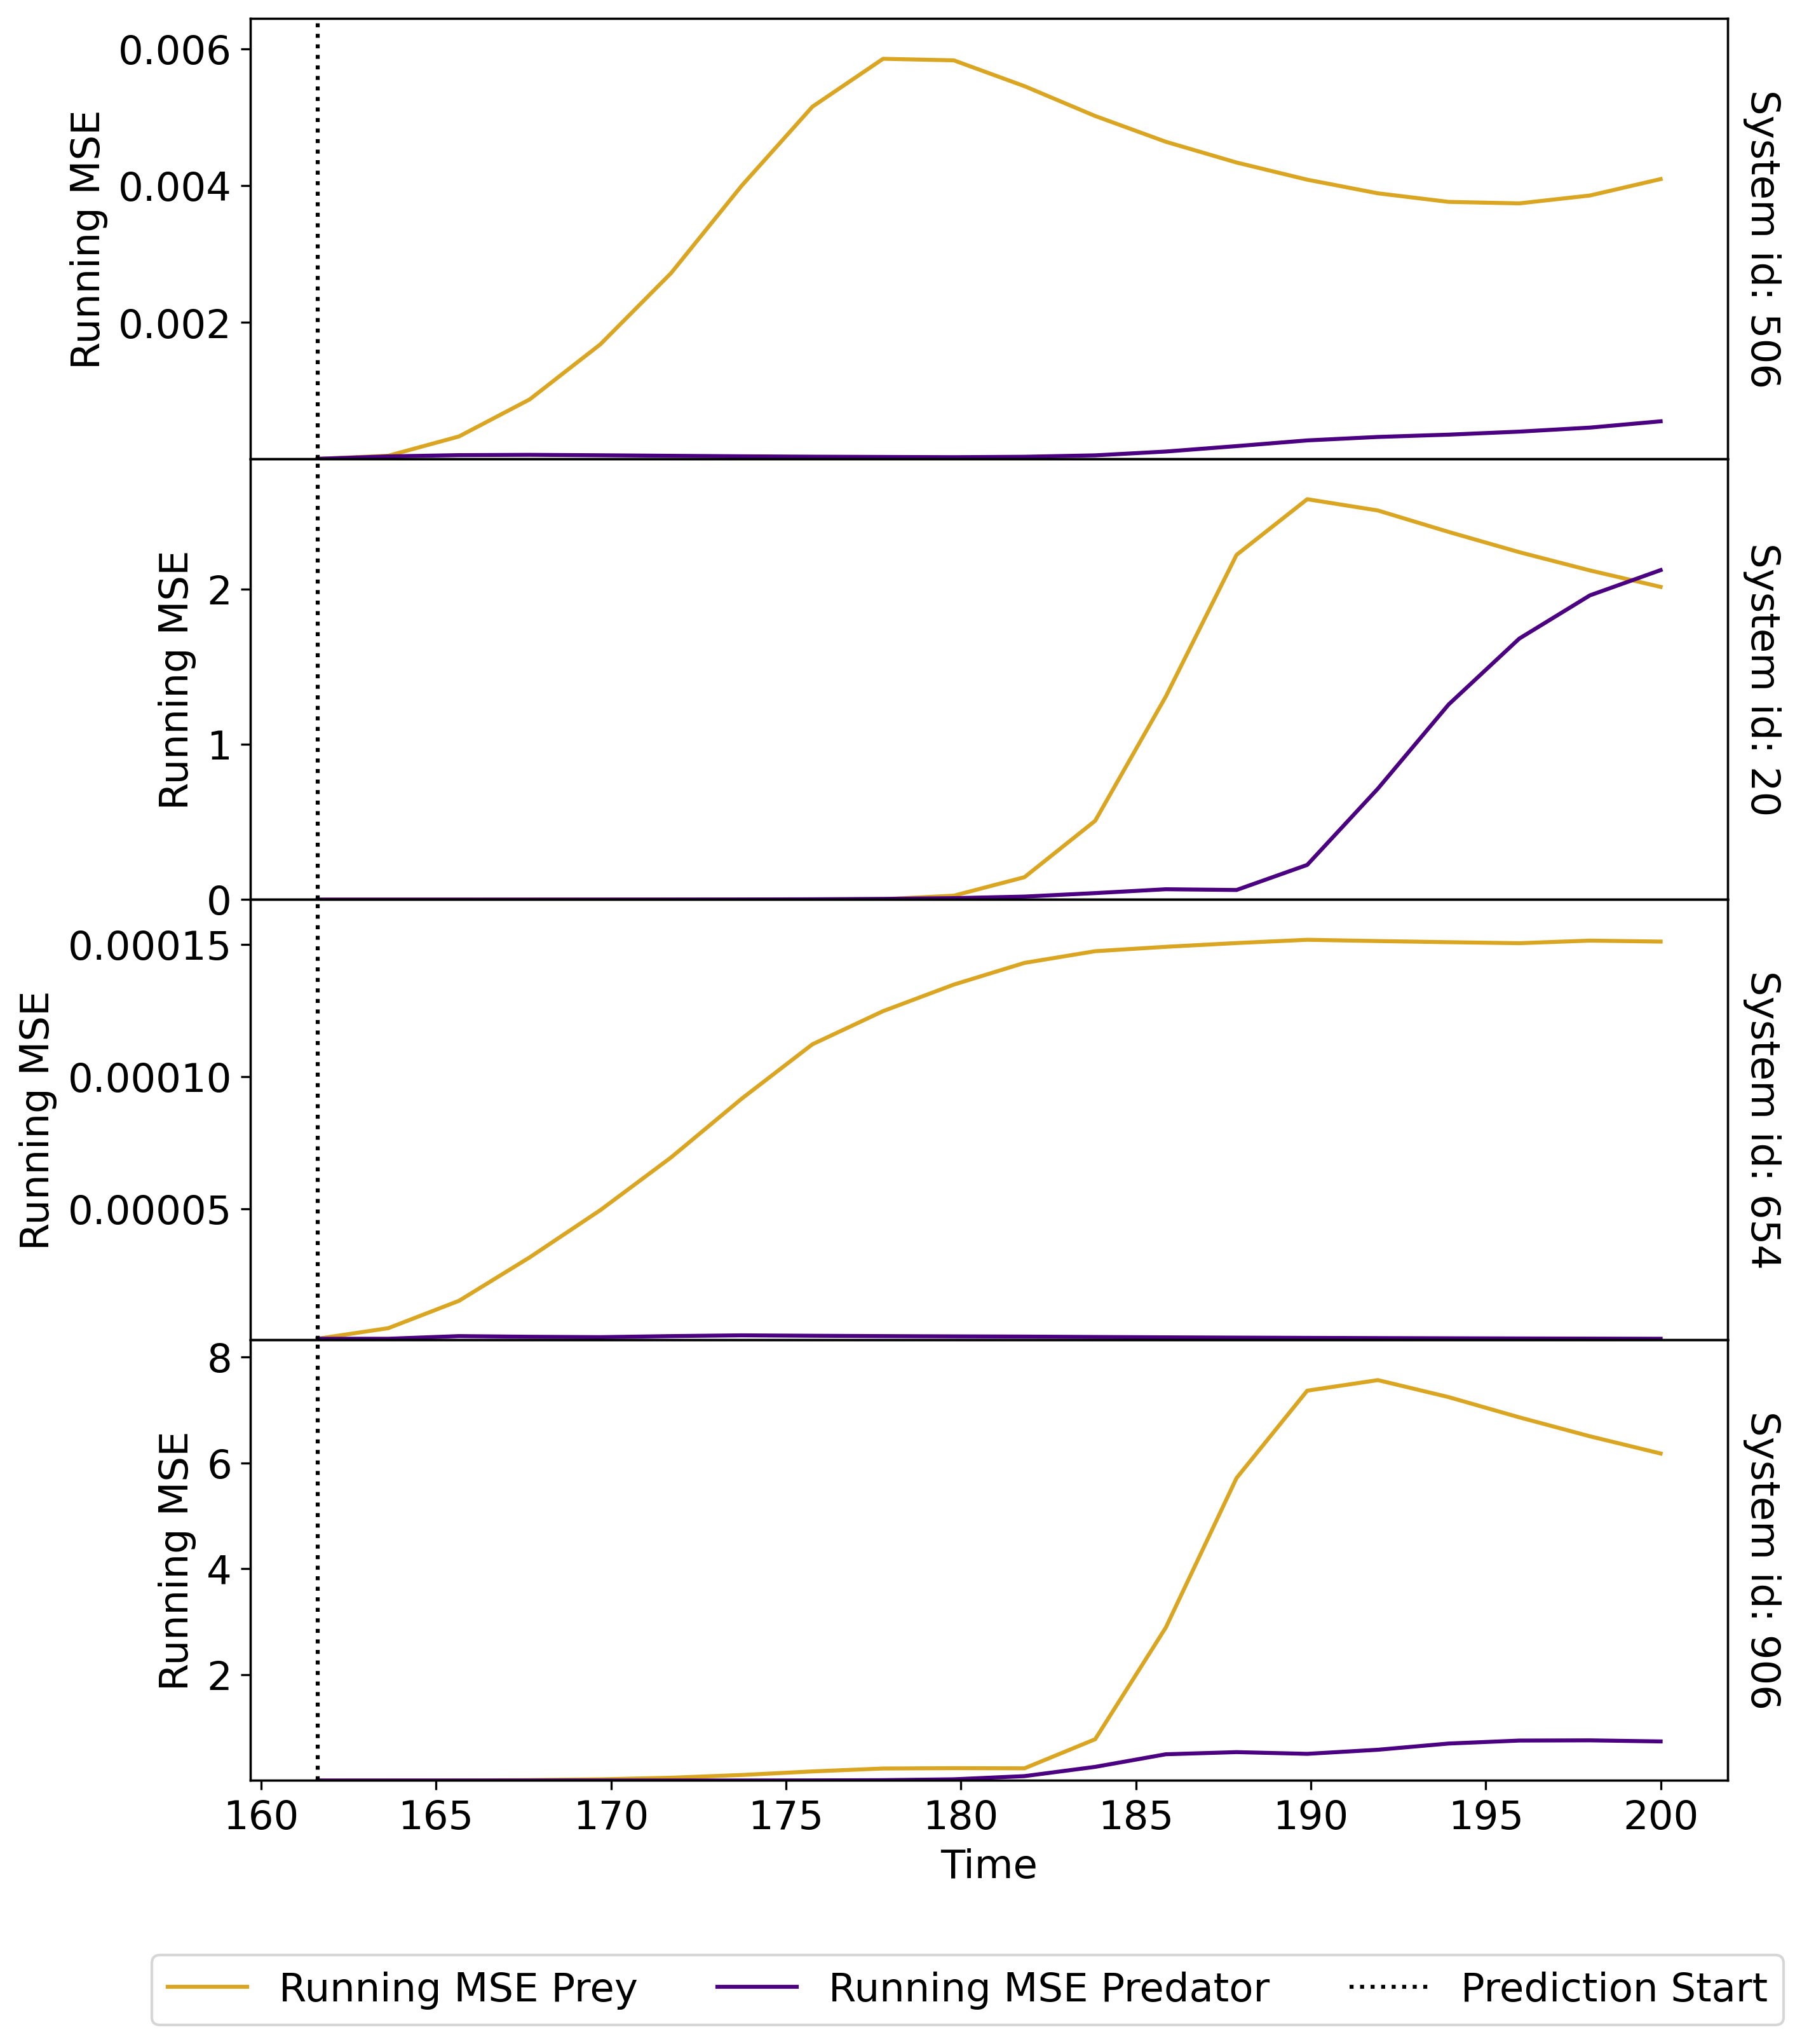

In [12]:
# plot the running MSE
metrics = get_metrics(actual_preys, actual_predators, pred_preys, pred_predators)
fig, ax = plt.subplots(len(actual_system_ids), 1, figsize=(10, 3*len(actual_system_ids)), sharex=True, dpi=300)
for i, id in enumerate(actual_system_ids):
    ax[i].plot(full_times[80:], metrics[i][-2], label='Running MSE Prey', color='goldenrod')
    ax[i].plot(full_times[80:], metrics[i][-1], label='Running MSE Predator', color='indigo')
    ax[i].set_ylabel('Running MSE')
    ax[i].set_ylim(min(min(metrics[i][-2]), min(metrics[i][-1]))*0.5, max(max(metrics[i][-2]), max(metrics[i][-1]))*1.1)
    twin_axis = ax[i].twinx()
    twin_axis.set_ylabel(fr'System id: {id}', rotation=270, fontsize=SMALL_SIZE-5, labelpad=20)
    twin_axis.set_yticks([])
    ax[i].axvline(x=full_times[80], color='black', linestyle='dotted', label='Prediction Start')
ax[i].set_xlabel('Time')
for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=SMALL_SIZE-5)
    ax.set_ylabel(ax.get_ylabel(), fontsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='minor', labelsize=SMALL_SIZE-5)
ax.legend(loc='lower left', bbox_to_anchor=(-0.08, -0.6), ncol=3, fontsize=SMALL_SIZE-5)
plt.subplots_adjust(hspace=0)
plt.savefig(f"../plots/running_mse_lora_final.png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
def print_metrics(metrics, system_ids):
    """
    Prints the metrics in a formatted table.

    Args:
        metrics (list): List of tuples containing calculated metrics for prey and predator.
        system_ids (list): List of system IDs corresponding to the metrics.

    Returns:
        None
    """
    df = pd.DataFrame(metrics, columns=["MSE Prey", "MSE Predator", "MAE Prey", "MAE Predator", "MAPE Prey", "MAPE Predator", "RMSE Prey", "RMSE Predator", "Running MSE Prey", "Running MSE Predator"])
    df["System ID"] = system_ids
    df.set_index("System ID", inplace=True)
    df = df.round(4)
    df.drop(columns=["Running MSE Prey", "Running MSE Predator"], inplace=True)
    display(df)

print_metrics(metrics, actual_system_ids)

MSE Prey  MSE Predator  MAE Prey  MAE Predator  MAPE Prey  \
System ID                                                              
506          0.0041        0.0006    0.0534        0.0180     0.0411   
20           2.0127        2.1207    0.7794        0.8806     0.2318   
654          0.0002        0.0000    0.0116        0.0007     0.0016   
906          6.1765        0.7385    1.4876        0.6015     0.3245   

           MAPE Predator  RMSE Prey  RMSE Predator  
System ID                                           
506               0.0146     0.0640         0.0236  
20                0.2313     1.4187         1.4563  
654               0.0007     0.0123         0.0010  
906               1.8874     2.4853         0.8594

In [14]:
# load training and validation losses from file
saved_results_path = f"../results/lora_run_{model_name}.pt"
result = torch.load(saved_results_path, weights_only=False, map_location=torch.device('cpu'))

train_losses = result['train_losses']
val_losses = result['val_losses']
every_50_steps = np.array(train_losses[:, 1])[::50]
every_50_steps_train = np.array(train_losses[:, 0])[::50]

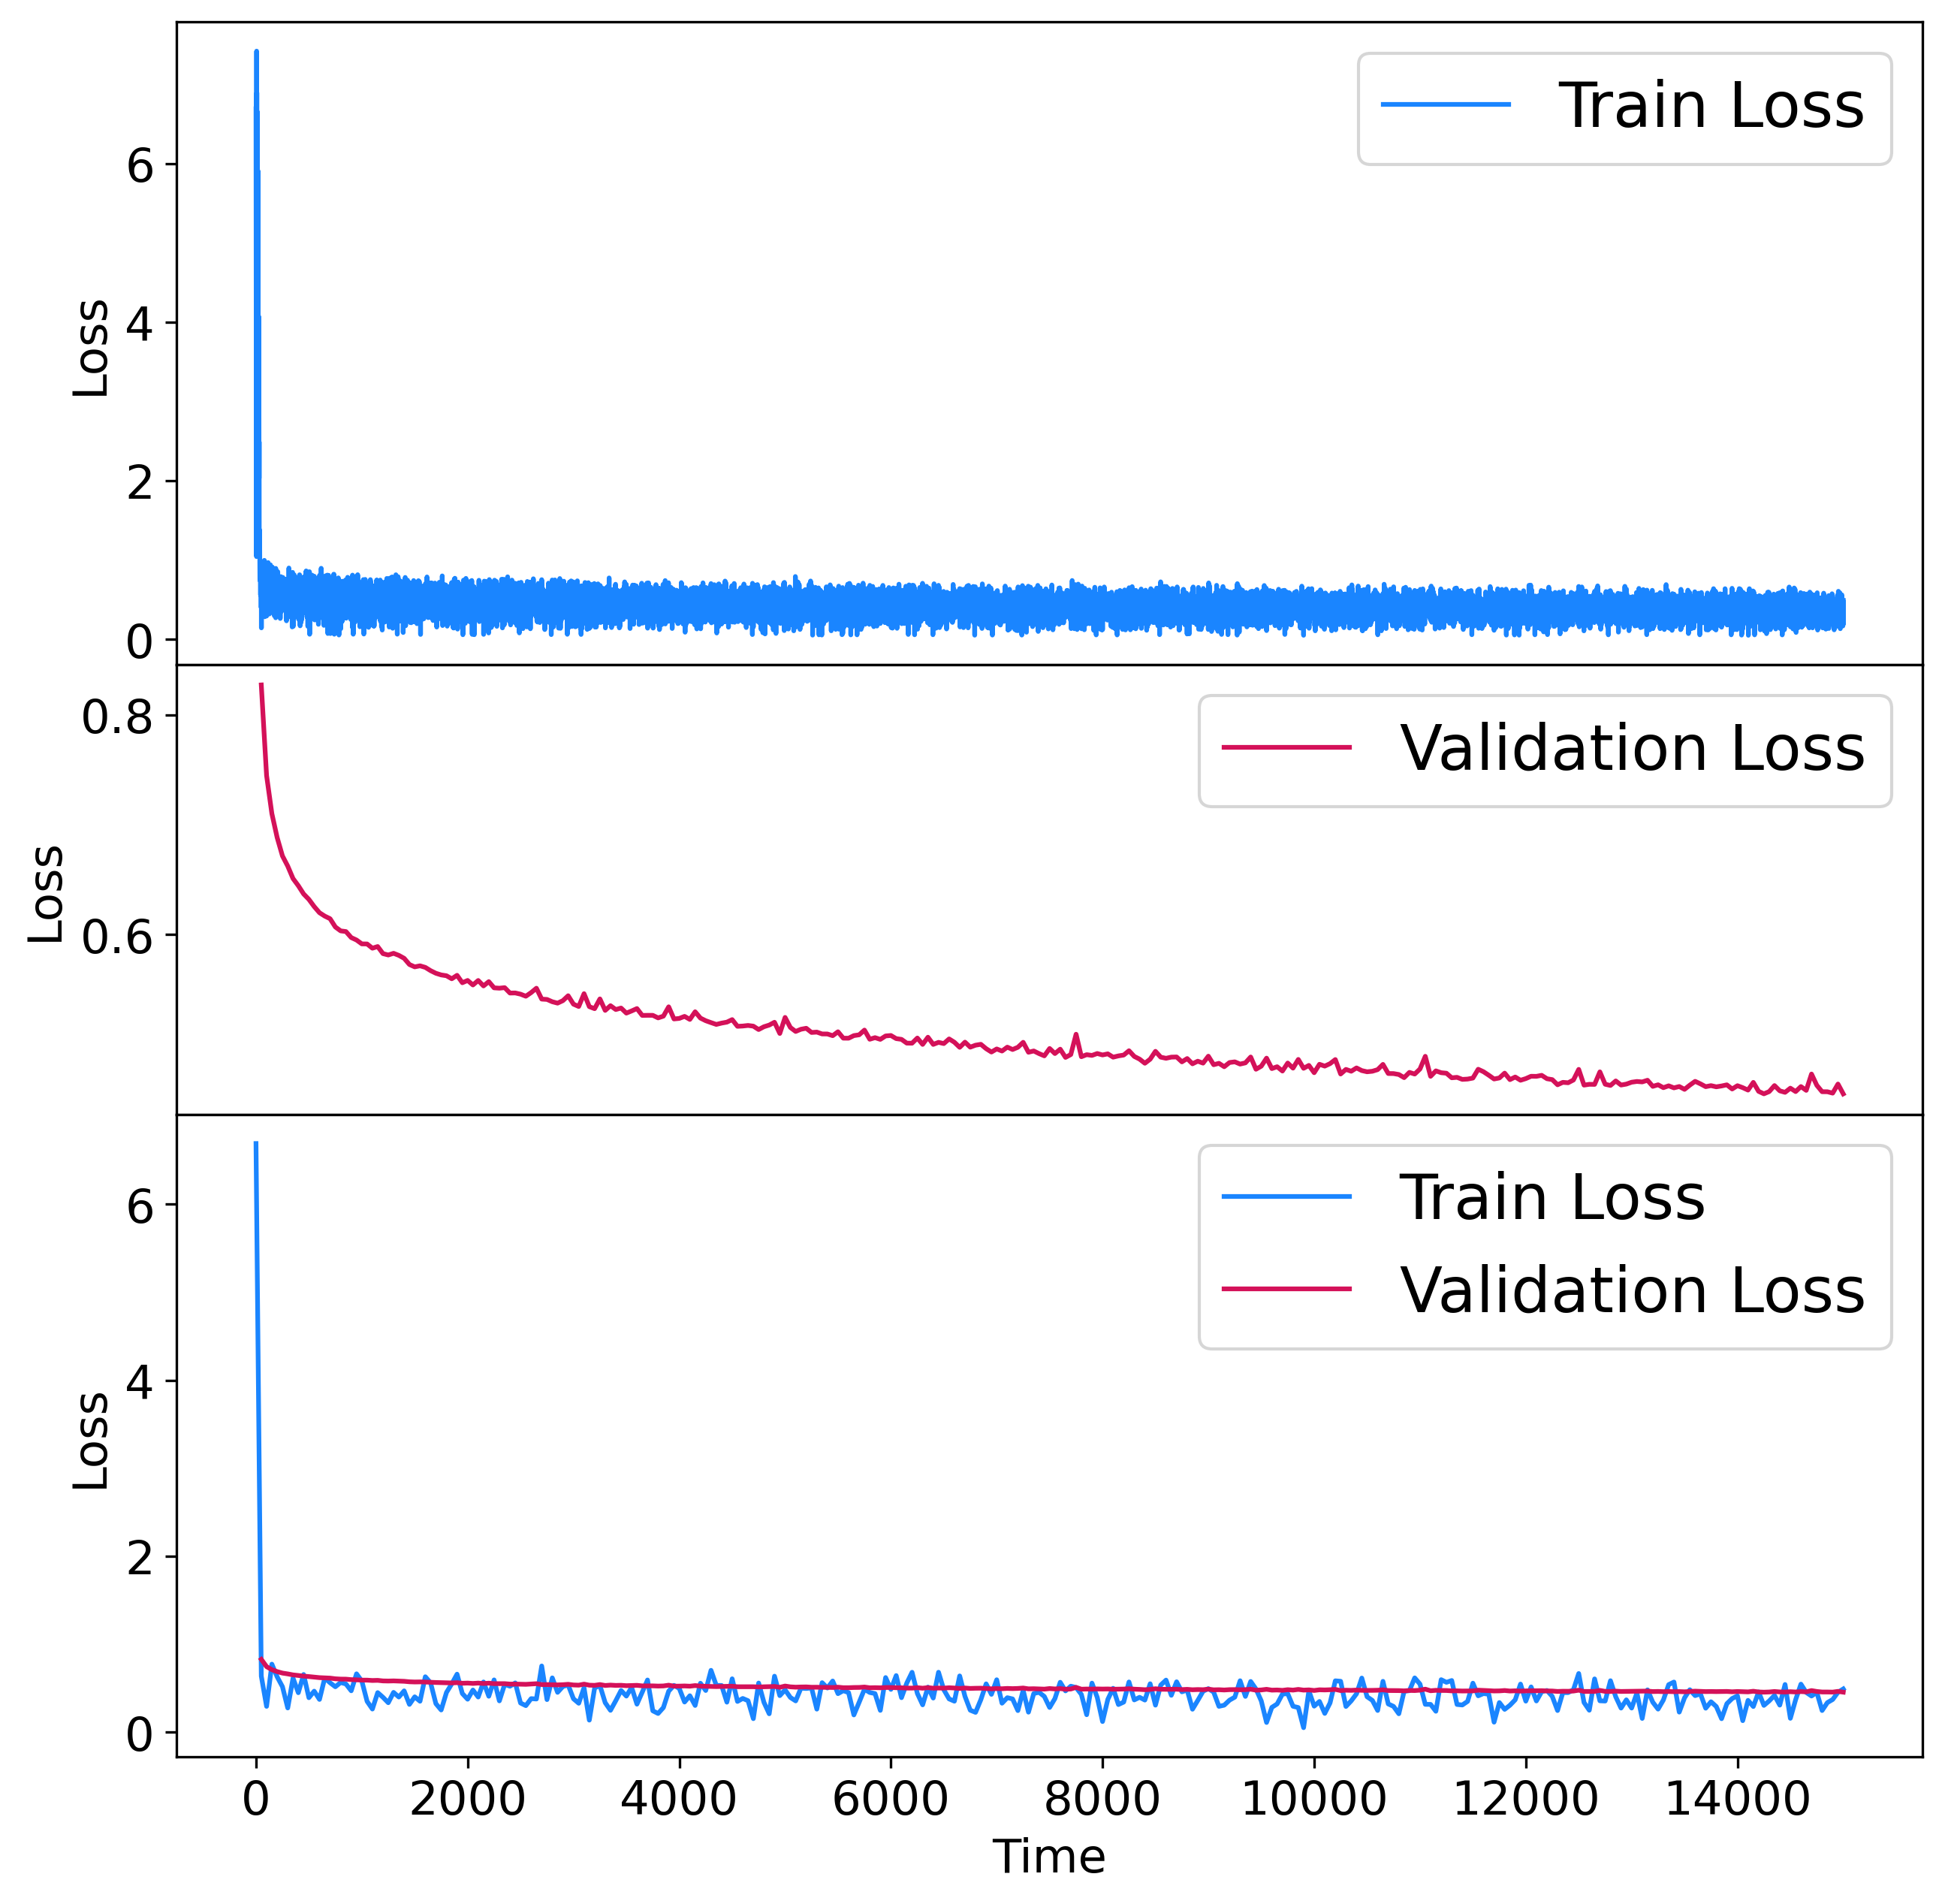

In [15]:
# plot training and validation loss
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True, dpi=300, height_ratios=[1, 0.7, 1])
ax[0].plot(train_losses[:,1], train_losses[:,0], label='Train Loss', color='#1A85FF')
ax[1].plot(val_losses[:,1], val_losses[:,0], label='Validation Loss', color='#D41159')
ax[2].plot(every_50_steps, every_50_steps_train, label='Train Loss', color='#1A85FF')
ax[2].plot(val_losses[:,1], val_losses[:,0], label='Validation Loss', color='#D41159')
ax[2].set_xlabel('Time')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Loss')
ax[2].set_ylabel('Loss')
ax[0].legend()
ax[1].legend()
ax[2].legend()
for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=SMALL_SIZE-5)
    ax.set_ylabel(ax.get_ylabel(), fontsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='minor', labelsize=SMALL_SIZE-5)
plt.subplots_adjust(hspace=0)
plt.savefig(f"../plots/lora_final_loss.png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
def gradientplot(result):
    """
    Plots gradients of the A and B matrices.

    Args:
        result (dict): dictionary loaded from file

    Returns:
        None
    """
    grad = result['grad_track']
    step = []
    gradients = np.zeros((len(grad), 24, 2, 2))
    for g in grad:
        for i in range(24):
            for proj in ("q_proj", "v_proj"):
                for matrix in ("A", "B"):
                    name = "{}.{}.{}".format(i, proj, matrix)
                    gradients[g['step']][i][0 if proj == "q_proj" else 1][0 if matrix == "A" else 1] = g['gradients'][name]

    fig, ax = plt.subplots(24, 2, figsize=(10, 100), sharex=True, dpi=300)
    for i in range(24):
        for j in range(2):
            twin_axis = ax[i][j].twinx()
            twin_axis.set_ylabel(f"Layer {i} - {'Q' if j == 0 else 'V'}", rotation=270, fontsize=SMALL_SIZE-5, labelpad=20)
            twin_axis.set_yticks([])
            for k in range(2):
                ax[i][j].plot([g[i][j][k] for g in gradients], label=f"{'A' if k == 0 else 'B'}")
                ax[i][j].legend(fontsize=SMALL_SIZE-5)

    for ax in ax.ravel():
        ax.set_xlabel(ax.get_xlabel(), fontsize=SMALL_SIZE-5)
        ax.set_ylabel(ax.get_ylabel(), fontsize=SMALL_SIZE-5)
        ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE-5)
        ax.tick_params(axis='both', which='minor', labelsize=SMALL_SIZE-5)
    
    plt.subplots_adjust(hspace=0, wspace=0.3)
    plt.savefig(f"../plots/lora_final_gradients.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"../addendum/lora_final_gradients.png", dpi=300, bbox_inches="tight")
    plt.show

gradientplot(result)